In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [ ]:
def show_uint8(img_uint8, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(img_uint8.permute(1,2,0)) # As plotting requires channel info last (axis)
    plt.axis("off")
    plt.show()

In [11]:
weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(
    weights=weights
).eval()

VOC_CLASSES = weights.meta["categories"]
len(VOC_CLASSES), VOC_CLASSES

(21,
 ['__background__',
  'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'])

In [12]:
@torch.no_grad()
def segment_objects(
    img_path,
    targets=("person",),
    alpha=0.5,
    colors=None,
):
    # Target classes
    target_ids = [VOC_CLASSES.index(t) for t in targets]

    # Load img
    img = Image.open(img_path).convert("RGB")
    img_tensor = T.ToTensor()(img)

    # Normalising img
    normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    x = normalize(img_tensor).unsqueeze(0)  # [1,C,H,W]

    # Run model
    pred_dict = seg_model(x)
    logits = pred_dict["out"][0] # [C, H, W]

    # Per-pixel class prediction
    pred = logits.argmax(0) # [H, W], choose the class that has the highest probability

    # Mask for target class
    masks = torch.stack([(pred == tid) for tid in target_ids])  # [K, H, W]

    # Prepare image for drawing
    img_uint8 = (img_tensor * 255).byte()  

    # Draw masks
    out = vutils.draw_segmentation_masks(
        img_uint8,
        masks=masks,
        alpha=alpha,
        colors=colors,
    )

    return out


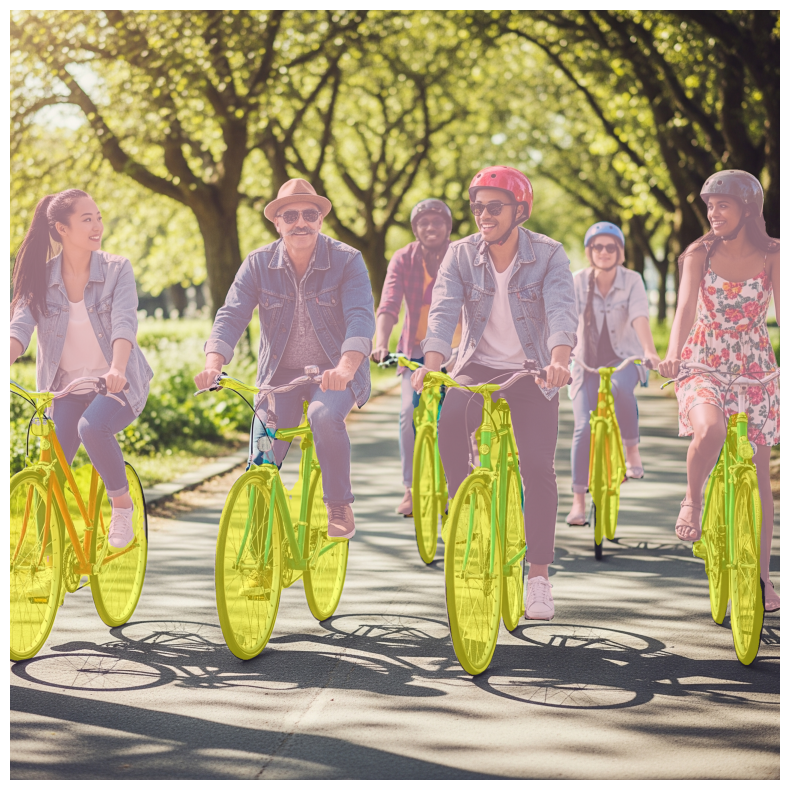

In [13]:
image_path = "/Users/chamu/vesuvius-scroll-detection/images/sandbox/person_and_bicycle.jpg"

out = segment_objects(
    image_path,
    targets=("person", "bicycle"),
    alpha=0.5,
    colors=["pink", "yellow"]
)

show_uint8(out, figsize=(10,10))